In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma
import numpy as np
import scipy
import statsmodels
import geopandas as gp
from shapely.geometry import Point

In [3]:
slowzones = gp.GeoDataFrame.from_file("neighborhood_slow_zones.json")

In [4]:
slowzone_details = [
    (6, 2013),  #New Brighton, change to 2013.  Month uncertain?
    (6, 2013),  #Corona, change to 2013
    (4, 2013),  #Jackson Heights/East Elmhurst, 
    (3, 2013),  #Elmhurst Month Uncertain
    (6, 2013),  #Auburndale
    (9, 2012),  #Inwood
    (12, 2012), #Baychester
    (9, 2013),  #Dongan
    (10, 2012), #Eastchester
    (10, 2012), #Riverdale
    (2, 2013),  #Rosebank, Not right
    (7, 2012),  #MT Eden, Definitely not right
    (11, 2012), #Boerum
    (11, 2011), #Claremont*
    (6, 2014),  #Norwood, Month uncertain
    (8, 2014),  #Alphabet*
    None,       #Clinton Hill REMOVE
    (9, 2014),  #Jackson-Heights*
    None,       #Brownsville/East
    None,       #Hudson Heights REMOVE
    None,       #Parkchester REMOVE
    (8, 2015),  #Sunnyside Gardens-Woodside*
    (8,2015),   #Sunnyside*
    None,       #West Village REMOVE
    (10, 2015), #Prospect Heights*
    (10, 2015), #Brooklyn Heights*
    (9, 2015)    #Astoria*
]

slowzones['date'] = [datetime.datetime(year=i[1], month=i[0], day=1) if i else None for i in slowzone_details]
slowzones = slowzones.drop(slowzones.index[[False if i else True for i in slowzone_details]])

In [5]:
slowzones['datefmt'] = slowzones.apply(lambda x: x['date'].strftime('%b %Y'), axis=1)
print slowzones.sort('date').to_latex(columns=['Name', 'datefmt'], index=False)

\begin{tabular}{ll}
\toprule
                                  Name &   datefmt \\
\midrule
                          Claremont SZ &  Nov 2011 \\
                            MT Eden SZ &  Jul 2012 \\
                             Inwood SZ &  Sep 2012 \\
                        Eastchester SZ &  Oct 2012 \\
                          Riverdale SZ &  Oct 2012 \\
                        Boerum Hill SZ &  Nov 2012 \\
                         Baychester SZ &  Dec 2012 \\
                           Rosebank SZ &  Feb 2013 \\
                           Elmhurst SZ &  Mar 2013 \\
      Jackson Heights/East Elmhurst SZ &  Apr 2013 \\
           New Brighton / St George SZ &  Jun 2013 \\
                         Auburndale SZ &  Jun 2013 \\
                             Corona SZ &  Jun 2013 \\
                       Dongan Hills SZ &  Sep 2013 \\
                           X10 Norwood &  Jun 2014 \\
 Alphabet City Tompkins Square Park SZ &  Aug 2014 \\
                    Jackson Heights SZ &  Se

In [6]:
def convertDate(d):
    #dt = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    #dt = dt.replace(minute=(dt.minute / 20) * 10, second=0, microsecond=0)
    dt = datetime.datetime.strptime(d, '%m/%d/%Y')
    #dt = dt.replace(day=1)
    #dt = dt - datetime.timedelta(hours=5)
    return dt

crashes = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv', converters={'DATE': convertDate})#, parse_dates=[1])

In [7]:
crashes['GEO'] = crashes.apply(lambda x: Point(x['LONGITUDE'], x['LATITUDE']), axis=1)

In [8]:
crashes = crashes.drop(crashes.index[np.isnan(crashes['LATITUDE'])])

In [9]:
def getSlowzone(crash):
    sz = slowzones[slowzones.intersects(crash['GEO'])]#.size
    if sz.size > 0:
        return sz.index[0]
    
    return float('nan')

In [10]:
crashes['slowzone'] = crashes.apply(getSlowzone, axis=1)

In [11]:
vz25date = datetime.datetime(year=2014, month=11, day=7)
def getSpeedLimit(crash):
    if not np.isnan(crash['slowzone']):
        if crash['DATE'] >= slowzones['date'][crash['slowzone']]:#slowzones.iloc[crash['slowzone']]['date']:
            return 20
        
    if crash['DATE'] > vz25date:
        return 25
    
    return 30

In [12]:
crashes['speedlimit'] = crashes.apply(getSpeedLimit, axis=1)

c:\Users\Jeremy\Anaconda\lib\site-packages\pandas\core\index.py:805: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  type(self).__name__),FutureWarning)


                            OLS Regression Results                            
Dep. Variable:                      k   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.905
Date:                Fri, 04 Dec 2015   Prob (F-statistic):             0.0547
Time:                        21:08:15   Log-Likelihood:             1.3140e+06
No. Observations:              596085   AIC:                        -2.628e+06
Df Residuals:                  596082   BIC:                        -2.628e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0007      0.000      2.275      0.0

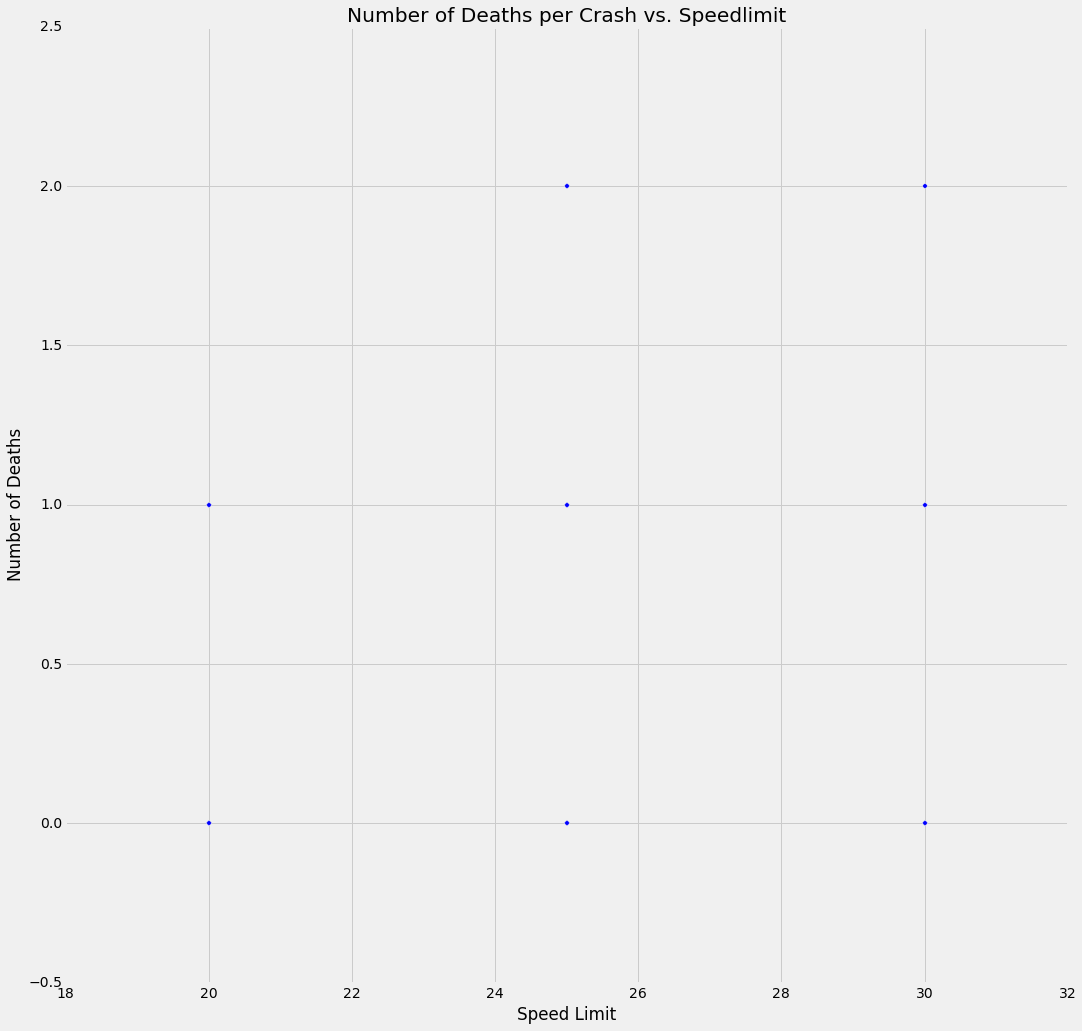

In [110]:
figure, ax = pl.subplots(figsize=(16,16))
#ax.plot_date(np.unique(crashes['DATE']), agg, '-')

subset = crashes#[crashes['PERCENT OF PEDESTRIANS KILLED']>=0]

ax.scatter(subset['speedlimit'], subset['NUMBER OF PEDESTRIANS KILLED'])

ax.set_title('Number of Deaths per Crash vs. Speedlimit')
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Speed Limit')

mod = smf.ols(formula='k ~ C(s)', data = {'s': subset['speedlimit'], 'k': subset['NUMBER OF PEDESTRIANS KILLED']}).fit()
print mod.summary()
#abline_plot(model_results=mod, ax=ax, color='red')
#y = mod.params[0] + mod.params[1]*np.arange(len(agg))
#ax.plot_date(np.unique(crashes['DATE']), y, 'r--')

In [13]:
grouped = crashes.groupby(('slowzone', 'speedlimit'))

In [28]:
#for name, group in grouped:
#    print name
slowzones['before'] = 0#np.zeros(slowzones.size)
slowzones['after'] = 0#np.zeros(slowzones.size)
for index,row in grouped.sum().iterrows():
    sz,speed = index
    if speed == 20:
        slowzones['after'][sz] += row['NUMBER OF PERSONS INJURED']
    else:
        slowzones['before'][sz] += row['NUMBER OF PERSONS INJURED']

c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
start = crashes.DATE.min()
end = crashes.DATE.max()
slowzones['avgBefore'] = slowzones.apply(lambda x: x['before']/(x['date'] - start).days if (x['date'] - start).days > 0 else float('nan'), axis=1)
slowzones['avgAfter'] = slowzones.apply(lambda x: x['after']/(end - x['date']).days if (end - x['date']).days > 0 else float('nan'), axis=1)

#print (end - start).days
slowzones

,Name,Shape_Leng,Year,geometry,date,before,after,avgBefore,avgAfter
0,New Brighton / St George SZ,13036.458032,2012,"POLYGON ((-74.08100100007188 40.6370809990848,...",2013-06-01,18,52,0.053731,0.057080
1,Corona SZ,10817.131818,2012,POLYGON ((-73.86942458231813 40.74915686824454...,2013-06-01,51,177,0.152239,0.194292
2,Jackson Heights/East Elmhurst SZ,11114.722878,2013,"POLYGON ((-73.88713100050958 40.7648889990303,...",2013-04-01,21,91,0.076642,0.093621
3,Elmhurst SZ,12877.813210,2013,POLYGON ((-73.88207112111411 40.74782992580317...,2013-03-01,65,212,0.267490,0.211366
4,Auburndale SZ,6477.631376,2013,POLYGON ((-73.78522788946755 40.76184569346055...,2013-06-01,5,9,0.014925,0.009879
5,Inwood SZ,13491.829126,2012,POLYGON ((-73.91845699967485 40.87306999944159...,2012-09-01,2,89,0.032258,0.075169
6,Baychester SZ,8972.379950,2013,"POLYGON ((-73.84640499958121 40.8770329992664,...",2012-12-01,15,101,0.098039,0.092406
7,Dongan Hills SZ,13195.014124,2013,POLYGON ((-74.09208699941692 40.58660899920393...,2013-09-01,22,50,0.051522,0.061050
8,Eastchester SZ,8453.375658,2013,"POLYGON ((-73.8555370004179 40.87118899883096,...",2012-10-01,2,28,0.021739,0.024263
9,Riverdale SZ,11343.380217,2013,POLYGON ((-73.91713000028915 40.89255099941862...,2012-10-01,0,17,0.000000,0.014731


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.3006
Date:                Fri, 04 Dec 2015   Prob (F-statistic):              0.587
Time:                        21:56:11   Log-Likelihood:                -208.42
No. Observations:                  42   AIC:                             420.8
Df Residuals:                      40   BIC:                             424.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      47.3463      7.925      5.974      

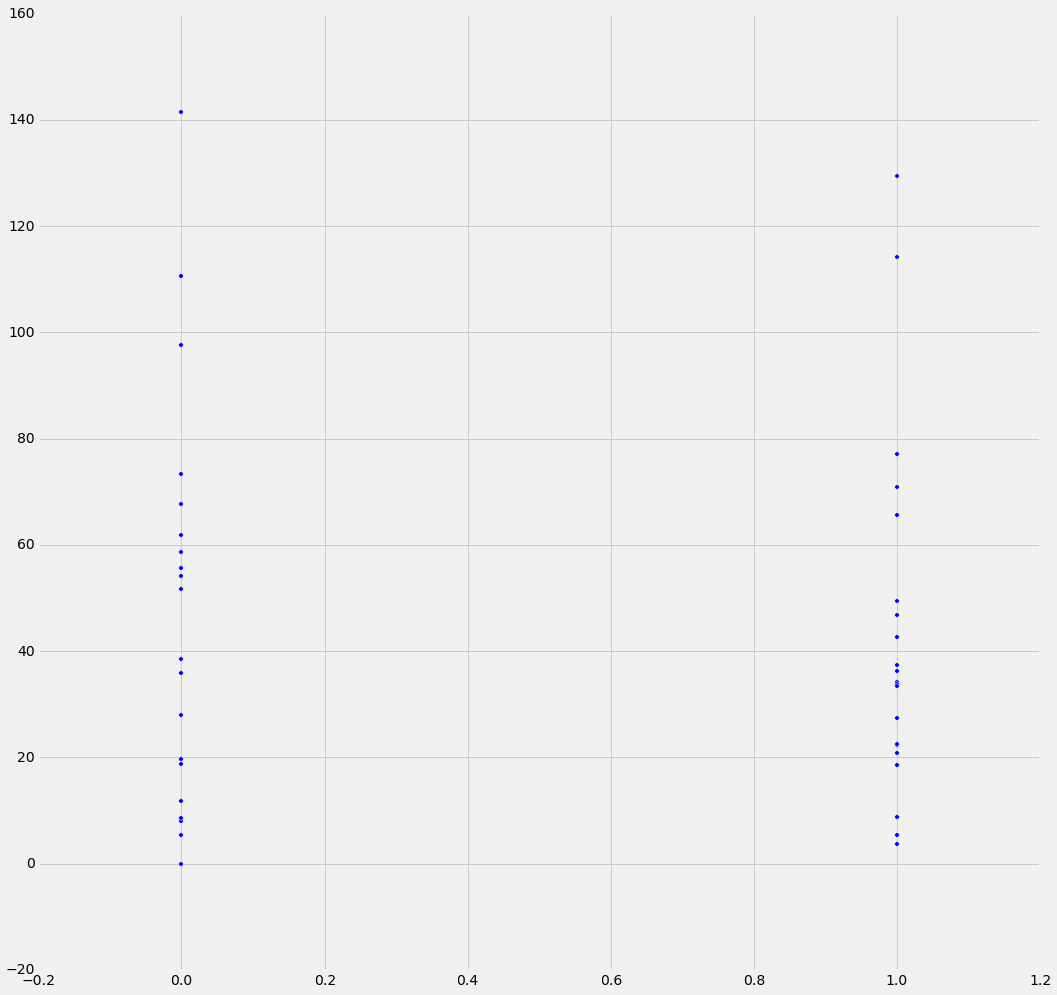

In [49]:
y = np.concatenate((slowzones['avgBefore'], slowzones['avgAfter']))*365
x = np.concatenate((np.zeros(len(slowzones)), np.ones(len(slowzones))))

figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(x,y)

mod = smf.ols(formula='y ~ C(x)', data = {'x': x, 'y': y}).fit()
print mod.summary()

In [63]:
slowzones.iloc[0]

Name                                New Brighton / St George SZ
Shape_Leng                                             13036.46
Year                                                       2012
geometry      POLYGON ((-74.08100100007188 40.6370809990848,...
date                                        2013-06-01 00:00:00
before                                                       18
after                                                        52
avgBefore                                            0.05373134
avgAfter                                             0.05708013
Name: 0, dtype: object

In [64]:
b = crashes[crashes.DATE < slowzones.iloc[0].date].sum()['NUMBER OF PERSONS INJURED']
a = crashes[crashes.DATE > slowzones.iloc[0].date].sum()['NUMBER OF PERSONS INJURED']

In [68]:
print b,a

41928.0 110958.0


In [65]:
scipy.stats.chisquare(
    [slowzones.iloc[0].before, slowzones.iloc[0].after],
    [b,a]
)

(152746.03209711419, 0.0)

In [67]:
print crashes[crashes.DATE < slowzones.iloc[0].date].mean()['NUMBER OF PERSONS INJURED']
print crashes[crashes.DATE > slowzones.iloc[0].date].mean()['NUMBER OF PERSONS INJURED']

0.270719801648
0.251795002133


In [28]:
#scipy.stats.chi2_contingency([
#    [slowzones.iloc[0].before, slowzones.iloc[0].after],
#    [b,a]
#])[1]

scipy.stats.chi2_contingency([
    [50, 45],
    [500, 1000]
], lambda_=0)[1]

0.00028171235498844743

In [34]:
def doStuff(col, results):
    print
    print col
    
    slowzones['before'] = 0
    slowzones['after'] = 0
    for index,row in grouped.sum().iterrows():
        sz,speed = index
        if speed == 20:
            slowzones['after'][sz] += row[col]
        else:
            slowzones['before'][sz] += row[col]
            
    for index,row in slowzones.iterrows():
        if row.before == 0:
            continue

        b = crashes[crashes.DATE < row.date].sum()[col]
        a = crashes[crashes.DATE > row.date].sum()[col]
        pvalue = scipy.stats.chi2_contingency([
            [row.before, row.after],
            [b,a]
        ], lambda_=0)[1]
        results.append((col, row.Name, row.date, row.before, row.after, b, a, pvalue))
        #print row.Name, row.date, row.before, row.after, b, a, pvalue

In [40]:
def doStuff2(results):
    col = 'GEO'
    slowzones['before'] = 0
    slowzones['after'] = 0
    for index,row in grouped.count().iterrows():
        sz,speed = index
        if speed == 20:
            slowzones['after'][sz] += row[col]
        else:
            slowzones['before'][sz] += row[col]
            
    for index,row in slowzones.iterrows():
        if row.before == 0:
            continue

        b = crashes[crashes.DATE < row.date].count()[col]
        a = crashes[crashes.DATE > row.date].count()[col]
        pvalue = scipy.stats.chi2_contingency([
            [row.before, row.after],
            [b,a]
        ], lambda_=0)[1]
        results.append((col, row.Name, row.date, row.before, row.after, b, a, pvalue))
        #print row.Name, row.date, row.before, row.after, b, a, pvalue

In [35]:
sum_categories = [
    'NUMBER OF PERSONS KILLED',
    'NUMBER OF PERSONS INJURED',
    'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF PEDESTRIANS INJURED',
    'NUMBER OF CYCLIST KILLED',
    'NUMBER OF CYCLIST INJURED',
    'NUMBER OF MOTORIST KILLED',
    'NUMBER OF MOTORIST INJURED'
]
        
percent_categories = [
    'PERCENT OF PERSONS KILLED',
    'PERCENT OF PEDESTRIANS KILLED',
    'PERCENT OF CYCLIST KILLED',
    'PERCENT OF MOTORIST KILLED',
]

In [36]:
results = []
for i in sum_categories:
    doStuff(i, results)

c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



NUMBER OF PERSONS KILLED

NUMBER OF PERSONS INJURED

NUMBER OF PEDESTRIANS KILLED

NUMBER OF PEDESTRIANS INJURED

NUMBER OF CYCLIST KILLED

NUMBER OF CYCLIST INJURED

NUMBER OF MOTORIST KILLED

NUMBER OF MOTORIST INJURED


In [41]:
r2 = []
doStuff2(r2)
print r2

c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[('GEO', u'New Brighton / St George SZ', Timestamp('2013-06-01 00:00:00'), 81L, 258L, 154876, 440668, 0.40580101702844495), ('GEO', u'Corona SZ', Timestamp('2013-06-01 00:00:00'), 179L, 556L, 154876, 440668, 0.32462651714163215), ('GEO', u'Jackson Heights/East Elmhurst SZ', Timestamp('2013-04-01 00:00:00'), 64L, 293L, 125058, 470620, 0.16685980616262541), ('GEO', u'Elmhurst SZ', Timestamp('2013-03-01 00:00:00'), 202L, 858L, 110984, 484596, 0.75485025703427688), ('GEO', u'Auburndale SZ', Timestamp('2013-06-01 00:00:00'), 42L, 85L, 154876, 440668, 0.094523058057610326), ('GEO', u'Inwood SZ', Timestamp('2012-09-01 00:00:00'), 28L, 480L, 29005, 566648, 0.57570716777167485), ('GEO', u'Baychester SZ', Timestamp('2012-12-01 00:00:00'), 36L, 294L, 70858, 524803, 0.63599114154386482), ('GEO', u'Dongan Hills SZ', Timestamp('2013-09-01 00:00:00'), 128L, 193L, 198949, 396732, 0.017908957378692445), ('GEO', u'Eastchester SZ', Timestamp('2012-10-01 00:00:00'), 7L, 114L, 43101, 552529, 0.652046834197

In [43]:
r3 = results + r2

In [46]:
rdf = pd.DataFrame(r3)

In [52]:
rdf = rdf.sort([2,1,0])

In [57]:
rdf2 = rdf[rdf[4] != 0]

In [68]:
rdf3 = rdf2[~rdf2[0].str.contains('KILLED')]

In [70]:
rdf3[0][rdf3[0].str.contains('GEO')] = 'Total Collisions'
rdf3[0][rdf3[0].str.contains('MOTORIST')] = 'Motorist Injuries'
rdf3[0][rdf3[0].str.contains('PEDESTRIAN')] = 'Pedestrian Injuries'
rdf3[0][rdf3[0].str.contains('PERSONS')] = 'Person Injuries'
rdf3[0][rdf3[0].str.contains('CYCLIST')] = 'Cyclist Injuries'

c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
c:\Users\Jeremy\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\Users\Jeremy\Anac

In [72]:
print rdf3.to_latex(columns=(1,2,0,3,4,5,6,7),index=False)

\begin{tabular}{lllrrrrr}
\toprule
                                     1 &          2 &                    0 &     3 &    4 &       5 &       6 &         7 \\
\midrule
                             Inwood SZ & 2012-09-01 &     Total Collisions &    28 &  480 &   29005 &  566648 &  0.575707 \\
                             Inwood SZ & 2012-09-01 &    Motorist Injuries &     1 &   46 &    5842 &  100047 &  0.450159 \\
                             Inwood SZ & 2012-09-01 &  Pedestrian Injuries &     1 &   31 &    1544 &   32487 &  0.967243 \\
                             Inwood SZ & 2012-09-01 &      Person Injuries &     2 &   89 &    8262 &  144663 &  0.217994 \\
                        Eastchester SZ & 2012-10-01 &     Total Collisions &     7 &  114 &   43101 &  552529 &  0.652047 \\
                        Eastchester SZ & 2012-10-01 &    Motorist Injuries &     2 &   20 &    8603 &   97295 &  0.818009 \\
                        Eastchester SZ & 2012-10-01 &      Person Injuries &     